# Supervised Learning Node Prediction
This program will generate a Supervised Learning model trained to predict the resultant properties of a given set of nodes in a graph

In [1]:
# Required Header
!pip install networkx numpy scikit-learn matplotlib pandas seaborn
%matplotlib inline

import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Algorithm Declaration

In [8]:
def generate_random_graph():
    """Generate random graph with varied topology"""
    graph_type = np.random.choice(['erdos', 'watts', 'barabasi'])
    n_nodes = np.random.randint(10, 50)
    
    if graph_type == 'erdos':
        p = np.random.uniform(0.1, 0.9)
        graph = nx.erdos_renyi_graph(n_nodes, p)
    elif graph_type == 'watts':
        k = np.random.randint(2, min(6, n_nodes-1))
        p = np.random.uniform(0.1, 0.9)
        graph = nx.watts_strogatz_graph(n_nodes, k, p)
    else:  # barabasi
        m = np.random.randint(1, 5)
        graph = nx.barabasi_albert_graph(n_nodes, m)
    
    return graph

def generate_random_subgraph():
    """Generate graph with random clustering patterns"""
    # Create base graph
    n_nodes = np.random.randint(10, 20)
    p = np.random.uniform(0, 1)
    graph = nx.erdos_renyi_graph(n_nodes, p)
    
    # Ensure connectivity
    while not nx.is_connected(graph):
        graph = nx.erdos_renyi_graph(n_nodes, p)
    
    # Select random nodes
    n_sample = np.random.randint(3, 7)
    nodes = list(np.random.choice(graph.nodes(), n_sample, replace=False))
    subgraph = graph.subgraph(nodes).copy()
    
    # Randomly modify edges to create diverse clustering
    possible_edges = list(combinations(nodes, 2))
    n_modifications = np.random.randint(0, len(possible_edges))
    edges_to_modify = np.random.choice(len(possible_edges), n_modifications, replace=False)
    
    for edge_idx in edges_to_modify:
        u, v = possible_edges[edge_idx]
        if subgraph.has_edge(u, v):
            subgraph.remove_edge(u, v)
        else:
            subgraph.add_edge(u, v)
    
    return subgraph

def generate_training_data(num_samples=1000):
    """Generate training data with random clustering"""
    X, y = [], []
    
    for _ in range(num_samples):
        subgraph = generate_random_subgraph()
        features = extract_features(subgraph)
        target = nx.average_clustering(subgraph)
        
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y)

def extract_features(graph):
    """Extract fixed-length feature vector"""
    n_nodes = len(graph)
    features = [
        nx.density(graph),
        len(graph.edges()) / n_nodes,
        np.mean([d for _, d in graph.degree()]),
        np.std([d for _, d in graph.degree()]),
        np.mean(list(nx.clustering(graph).values())),
        nx.transitivity(graph)
    ]
    return np.array(features)

## Simulation and Analysis

In [9]:
# Generate training data
X, y = generate_training_data(num_samples=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model with tuned parameters
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validation MSE: {-scores.mean():.4f} (+/- {scores.std() * 2:.4f})')

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': range(X_train.shape[1]),
    'importance': model.feature_importances_
})
print("\nTop 5 important features:")
print(feature_importance.nlargest(5, 'importance'))

NameError: name 'combinations' is not defined

Mean Squared Error: 0.0332
R² Score: 0.6848


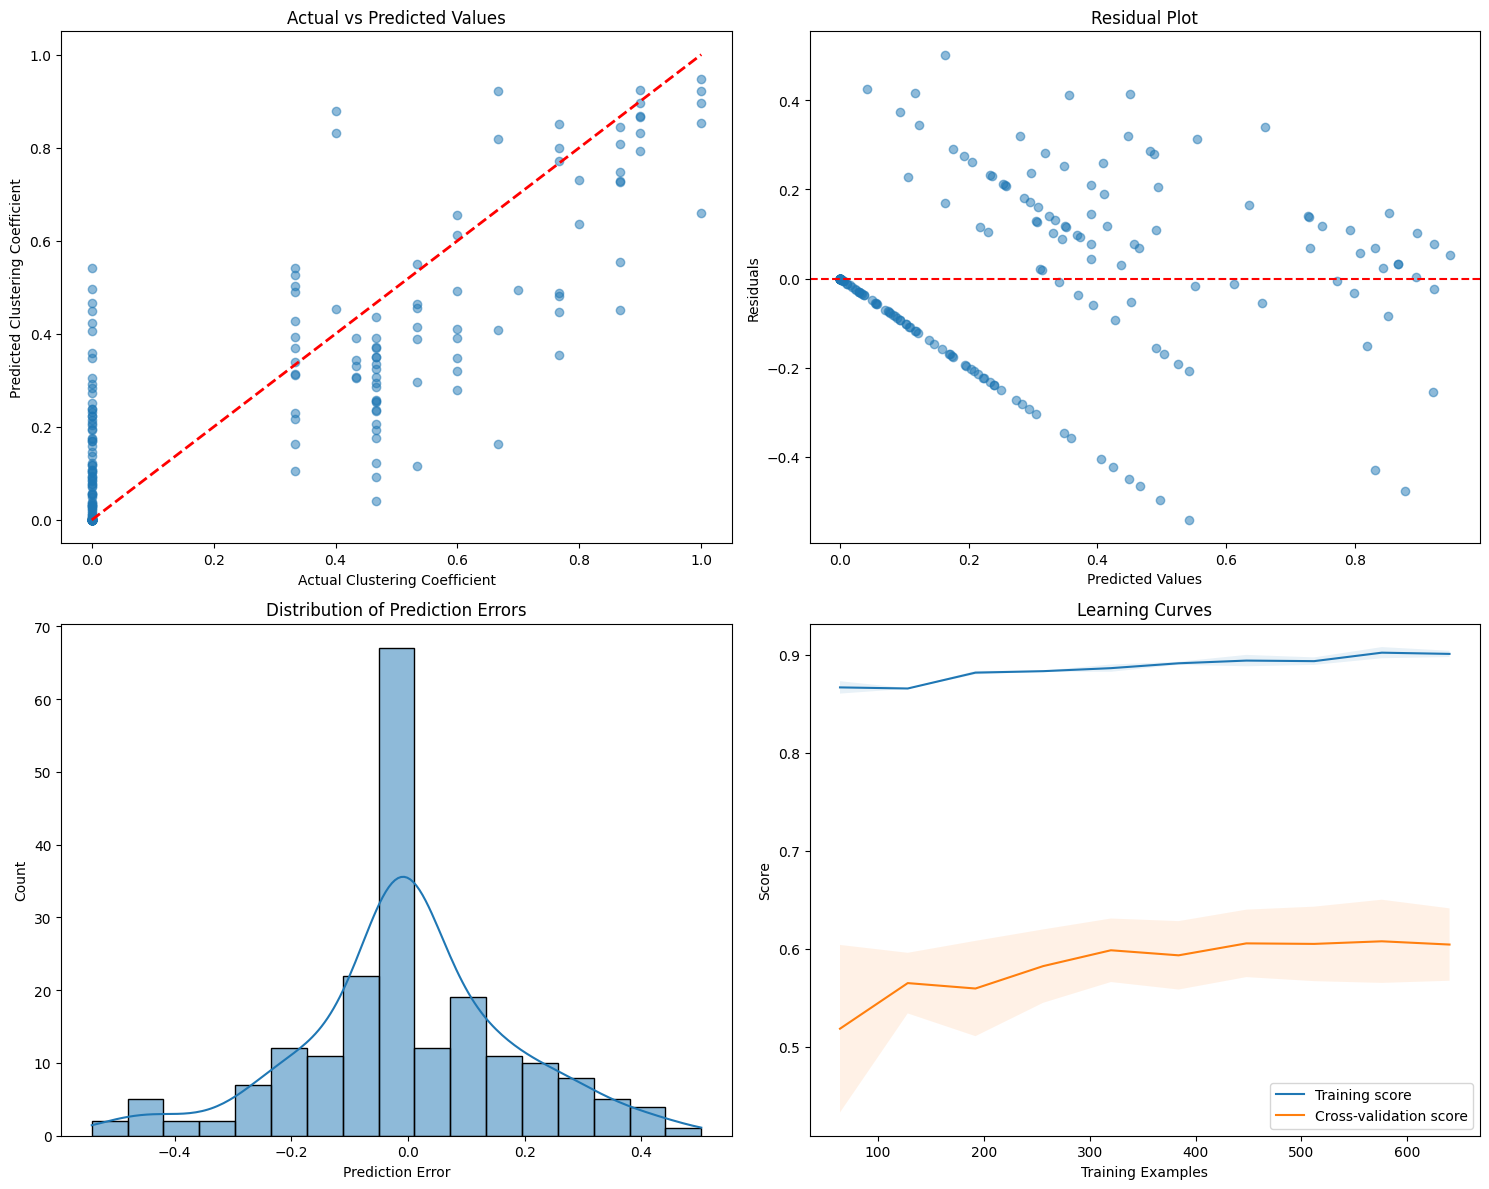

In [7]:
def plot_model_accuracy(model, X_test, y_test, X_train, y_train):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Actual vs Predicted
    ax1.scatter(y_test, y_pred, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Clustering Coefficient')
    ax1.set_ylabel('Predicted Clustering Coefficient')
    ax1.set_title('Actual vs Predicted Values')
    
    # 2. Residual Plot
    residuals = y_test - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    
    # 3. Error Distribution
    sns.histplot(residuals, kde=True, ax=ax3)
    ax3.set_xlabel('Prediction Error')
    ax3.set_title('Distribution of Prediction Errors')
    
    # 4. Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    ax4.plot(train_sizes, train_mean, label='Training score')
    ax4.plot(train_sizes, test_mean, label='Cross-validation score')
    ax4.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    ax4.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    ax4.set_xlabel('Training Examples')
    ax4.set_ylabel('Score')
    ax4.set_title('Learning Curves')
    ax4.legend(loc='best')
    
    # Print metrics
    print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}')
    print(f'R² Score: {r2_score(y_test, y_pred):.4f}')
    
    plt.tight_layout()
    plt.show()

# Call the function after model training
plot_model_accuracy(model, X_test, y_test, X_train, y_train)